In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from itertools import cycle

# Initial Condition


In [2]:
def initial_cond(x):
    y = np.sin(2*np.pi*x)
    return y


# Mesh


In [3]:
def mesh(k, lamb):
    h = k * lamb**(-1)
    x = np.arange(0, 1, h)
    x = np.append(x, np.array([1]))
    
    t = np.arange(0, 0.5, k)
    t = np.append(t, np.array([0.5]))
    
    xx, tt = np.meshgrid(x, t)
    exact_mesh = xx - t[:, np.newaxis]
    
    u = np.zeros_like(xx)
    u[0, :] = initial_cond(x)
    
    return xx, (u, exact_mesh)

# Exact Solution

In [4]:
def exact_sol(mesh):
    y = np.sin(2*np.pi*mesh)

    return y


# Plotting

In [5]:
def plotting_anim(x, ux, title='', skip_rate=1, labels=None, fmts=None):
    """
    x --> mesh --> (N_steps, N_space)
    ux --> [ux_1, ux_2, ..., exact] --> (N_sols, N_steps, N_space)
    """
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$u(t, x)$')
    ax.grid(True)
    ax.set_title(title)
    
    ux = np.asarray(ux)
    ux = ux[:, ::skip_rate, :]
    
    # The number of solutions.
    n_sols = ux.shape[0]

    if labels is None:
        labels = ['NSol_' + str(i) for i in range(1, n_sols)]
        labels.append('Exact')

    if fmts is None:
        fmts = [c for _, c in zip(range(n_sols), cycle('bgrcmyk'))]
        fmts[0] += '-'

    lines = []
    for _, fmt, l in zip(reversed(ux), reversed(fmts), reversed(labels)):
        line, = ax.plot([], [], fmt, label=l, alpha=0.9, lw=5)
        lines.append(line)
        ax.set_xlim(0, 1)
        ax.set_ylim(-2, 2)
    fig.legend()

    def animate(frame_num):
        ax.set_title(f'{title} FRAME={frame_num * skip_rate:04d}')
        for line, u, x_coord in zip(lines, ux, x):
            y = u[frame_num, :]
            line.set_data((x_coord, y))
        return lines

    anim = FuncAnimation(fig, animate, frames=ux[0].shape[0], interval=100)
    video = anim.to_jshtml()
    html = display.HTML(video)
    display.display(html)
    plt.close()

## Leapfrog
$$ \frac{v_{m}^{n+1} - v_{m}^{n-1}}{2k} + a\frac{v_{m+1}^{n} - v_{m-1}^{n}}{2h} $$
$$ v_{m}^{n+1} = v_{m}^{n-1} -\lambda( v_{m+1}^{n} - v_{m-1}^{n})$$
Only `2-step` in this problem set. So I used first step, Lax - Friedrichs.

### With boundary condition (a)
$$v_{M}^{n+1} = 2v_{M-1}^{n+1} - v_{M-2}^{n+1}$$

In [6]:
def leapfrog1(k, lamb):
    x, (u, exact) = mesh(k, lamb)
    exactsol = exact_sol(exact)
    left = exact_sol(exact[:, 0])
    u[:, 0] = left
    u[1, 1:-1] = 1/2 * (1-lamb)*u[0, 2:] + (1/2)*(1+lamb)*u[0, 0:-2]
    u[1, -1] = 2*u[1, -2] - u[1, -3]
    for i in range(1, u.shape[0]-1):
        u[i+1, 1:-1] = u[i-1,  1:-1] - lamb*(u[i, 2:] - u[i, :-2])
        u[i+1, -1] = 2*u[i+1, -2] - u[i+1, -3]

    return x, [u, exactsol]

### With boundary condition (b)
$$v_{M}^{n+1} = v_{M-1}^{n}

In [7]:
def leapfrog2(k, lamb):
    x, (u, exact) = mesh(k, lamb)
    exactsol = exact_sol(exact)
    left = exact_sol(exact[:, 0])
    u[:, 0] = left
    u[1, 1:-1] = 1/2 * (1-lamb)*u[0, 2:] + (1/2)*(1+lamb)*u[0, 0:-2]
    u[1, -1] = u[0, -2]
    for i in range(1, u.shape[0]-1):
        u[i+1, 1:-1] = u[i-1,  1:-1] - lamb*(u[i, 2:] - u[i, :-2])
        u[i+1, -1] = u[i, -2]
    return x, [u, exactsol]

In [8]:
x, ux1 = leapfrog1(0.02, 0.9)
_, ux2 = leapfrog2(0.02, 0.9)

In [9]:
plotting_anim(x, [*ux1], title='Problem $(a)$', skip_rate=1, fmts=('c.', 'r-'))
plotting_anim(x, [*ux2], title='Problem $(b)$', skip_rate=1, fmts=('c.', 'r-'))

In [10]:
plotting_anim(x, [ux1[0], *ux2], fmts=('c.', 'gs', 'r-'))

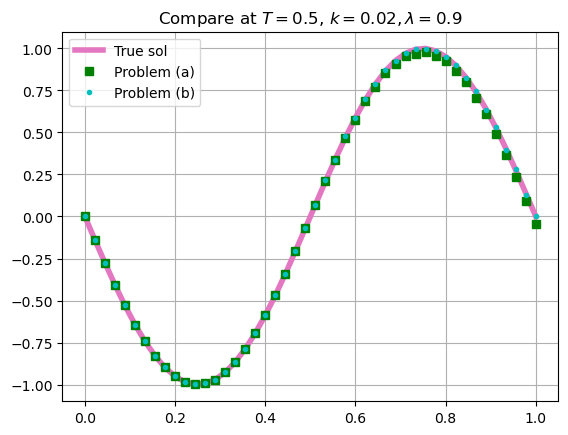

In [11]:
plt.plot(x[-1, :], ux1[1][-1, :], c='C6', label='True sol', alpha=1, lw=4)
plt.plot(x[-1, :], ux1[0][-1, :], 'gs', label='Problem (a)')
plt.plot(x[-1, :], ux2[0][-1, :], 'c.', label='Problem (b)')
plt.legend()
plt.grid(True)
plt.title("Compare at $T=0.5$, $k=0.02, \lambda = 0.9$")
plt.show()